In [44]:
library(SnapATAC)
library(ggplot2)
library(viridisLite)
library(GenomicRanges)

## Barcode selection

In [45]:
x.sp = createSnap(
    file="scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3.snap",
    sample="scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3",
    num.cores=50
  )

Epoch: reading the barcode session ...



In [46]:
barcodes = read.csv(
    "singlecell.csv",
    head=TRUE
  )

#barcodes=read.csv("scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3.barcodes.txt",header=TRUE)

In [47]:
head(barcodes)

,barcode,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,cell_id,is__cell_barcode,TSS_fragments,DNase_sensitive_region_fragments,enhancer_region_fragments,promoter_region_fragments,on_target_fragments,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,NO_BARCODE,4702679,1713086,42740,699367,278907,147629,1820950,None,0,0,0,0,0,0,0,0,0
2,AAACGAAAGAAACGCC,7,1,0,2,0,0,4,None,0,1,3,2,1,3,0,1,2
3,AAACGAAAGAAAGCAG,3,0,0,1,0,0,2,None,0,0,0,0,0,0,0,0,0
4,AAACGAAAGAAAGGGT,5,0,0,0,0,0,5,None,0,3,3,1,1,5,0,3,6
5,AAACGAAAGAAATACC,22,7,1,11,0,0,3,None,0,1,0,0,0,1,0,0,0
6,AAACGAAAGAAATCTG,6,0,0,2,1,0,3,None,0,1,2,0,1,2,0,2,4


In [50]:
barcodes = barcodes[2:nrow(barcodes),];
promoter_ratio = (barcodes$promoter_region_fragments+1) / (barcodes$passed_filters + 1);
UMI = log(barcodes$passed_filters+1, 10);
data = data.frame(UMI=UMI, promoter_ratio=promoter_ratio);
barcodes$promoter_ratio = promoter_ratio;


In [51]:
p1 = ggplot(
    data, 
    aes(x= UMI, y= promoter_ratio)) + 
    geom_point(size=0.1, col="grey") +
    theme_classic() +
    ggtitle("scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3") +
    ylim(0, 1) + xlim(0, 6) +
    labs(x = "log10(UMI)", y="promoter ratio") 

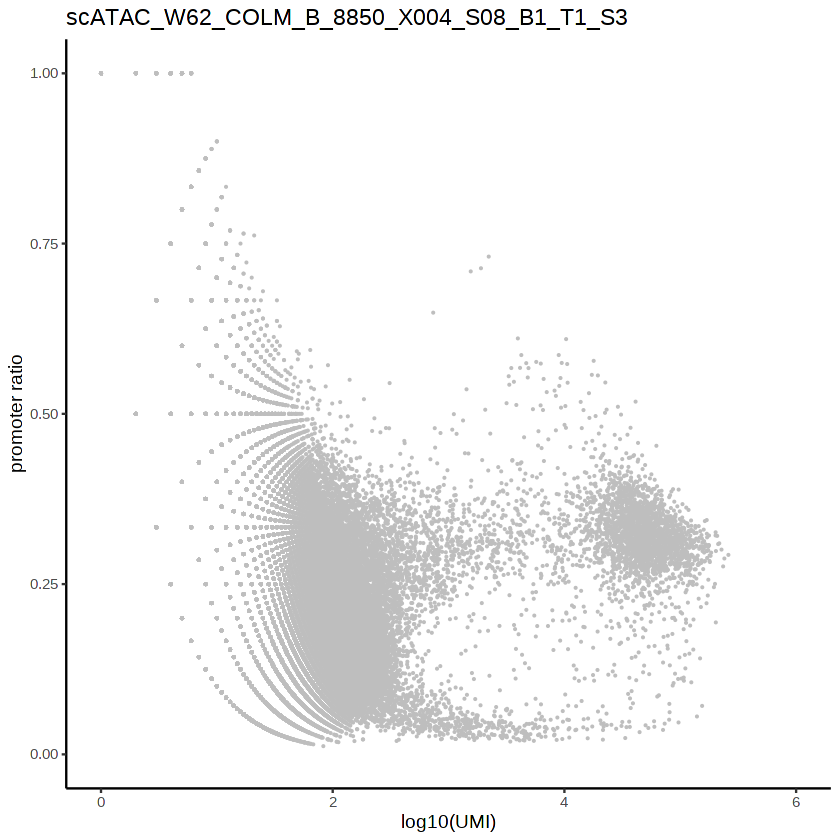

In [52]:
p1

In [53]:
barcodes.sel = barcodes[which(UMI >= 3 & UMI <= 5 & promoter_ratio >= 0.16 & promoter_ratio <= 0.8),];
rownames(barcodes.sel) = barcodes.sel$barcode;


In [54]:
x.sp = x.sp[which(x.sp@barcode %in% barcodes.sel$barcode),];
x.sp@metaData = barcodes.sel[x.sp@barcode,];
x.sp

number of barcodes: 2645
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

## Add cell-by-bin matrix

In [55]:
showBinSizes("scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3.snap")

[1]    50  1000  2000  5000 10000

In [56]:
x.sp = addBmatToSnap(x.sp, bin.size=5000, num.cores=1)

Epoch: reading cell-bin count matrix session ...



## Matrix binarization

In [57]:
x.sp = makeBinary(x.sp, mat="bmat")

## Bin filtering 

In [58]:
system('wget http://mitra.stanford.edu/kundaje/akundaje/release/blacklists/hg38-human/hg38.blacklist.bed.gz')

In [59]:
black_list=read.table("hg38.blacklist.bed.gz")
black_list.gr=GRanges(black_list[,1],IRanges(black_list[,2],black_list[,3]))

In [60]:
idy = queryHits(findOverlaps(x.sp@feature, black_list.gr))

In [61]:
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="bmat"]}

In [62]:
x.sp

number of barcodes: 2645
number of bins: 620068
number of genes: 0
number of peaks: 0
number of motifs: 0

In [63]:
## remove unwanted chroms 

In [64]:
chr.exclude = seqlevels(x.sp@feature)[grep("random|chrM", seqlevels(x.sp@feature))];
idy = grep(paste(chr.exclude, collapse="|"), x.sp@feature);
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="bmat"]};
x.sp

number of barcodes: 2645
number of bins: 618645
number of genes: 0
number of peaks: 0
number of motifs: 0

number of barcodes: 2645
number of bins: 542288
number of genes: 0
number of peaks: 0
number of motifs: 0

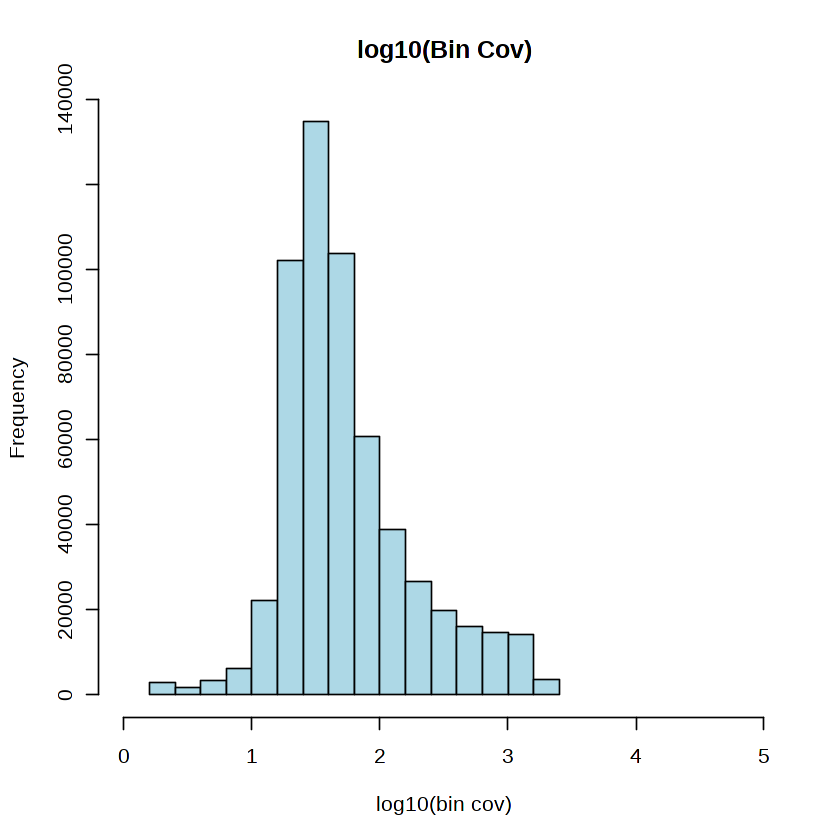

In [65]:
#Bin filtering
bin.cov = log10(Matrix::colSums(x.sp@bmat)+1);
hist(
    bin.cov[bin.cov > 0], 
    xlab="log10(bin cov)", 
    main="log10(Bin Cov)", 
    col="lightblue", 
    xlim=c(0, 5)
  );
bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95);
idy = which(bin.cov <= bin.cutoff & bin.cov > 0);
x.sp = x.sp[, idy, mat="bmat"];
x.sp

## Dimensionality reduction -- diffusion maps

In [66]:
x.sp = runDiffusionMaps(
    obj=x.sp,
    input.mat="bmat", 
    num.eigs=50
  )

rowCovs = Matrix::rowSums(x.sp@bmat)

Epoch: checking the inputs ...

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



## Determine significant components 

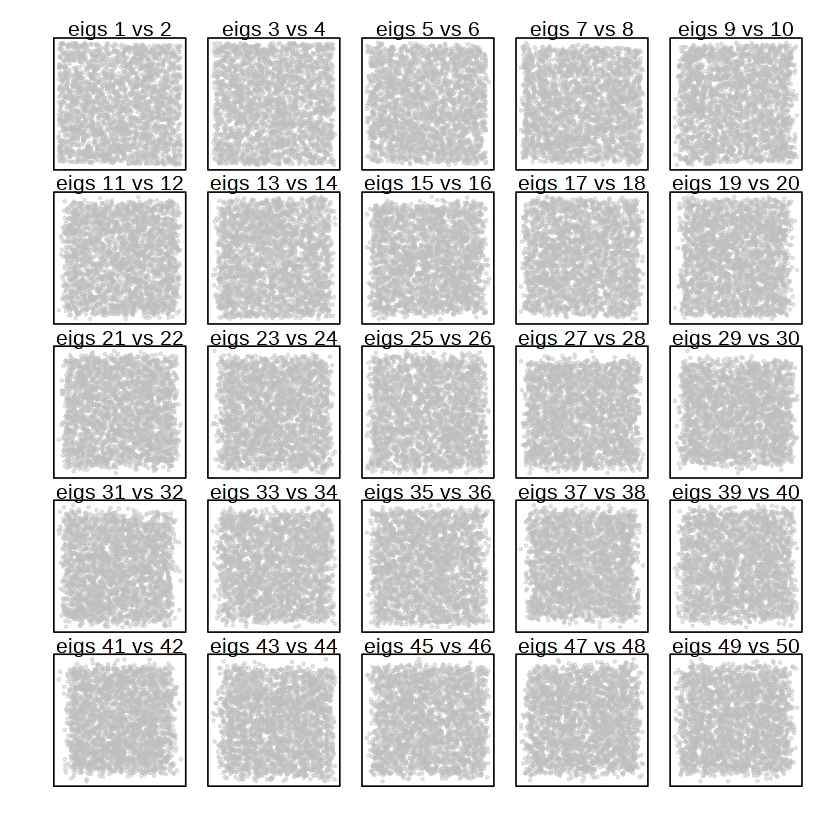

In [70]:
plotDimReductPW(
    obj=x.sp, 
    eigs.dims=1:50,
    point.size=0.3,
    point.color="grey",
    point.shape=19,
    point.alpha=0.6,
    down.sample=5000,
    pdf.file.name=NULL, 
    pdf.height=7, 
    pdf.width=7
  )

## Graph-based clustering

In [68]:
x.sp = runKNN(
    obj=x.sp,
    eigs.dims=1:20,
    k=15
  )
x.sp=runCluster(
    obj=x.sp,
    tmp.folder=tempdir(),
    louvain.lib="R-igraph",
    seed.use=10
  )
x.sp@metaData$cluster = x.sp@cluster;

## Visualization

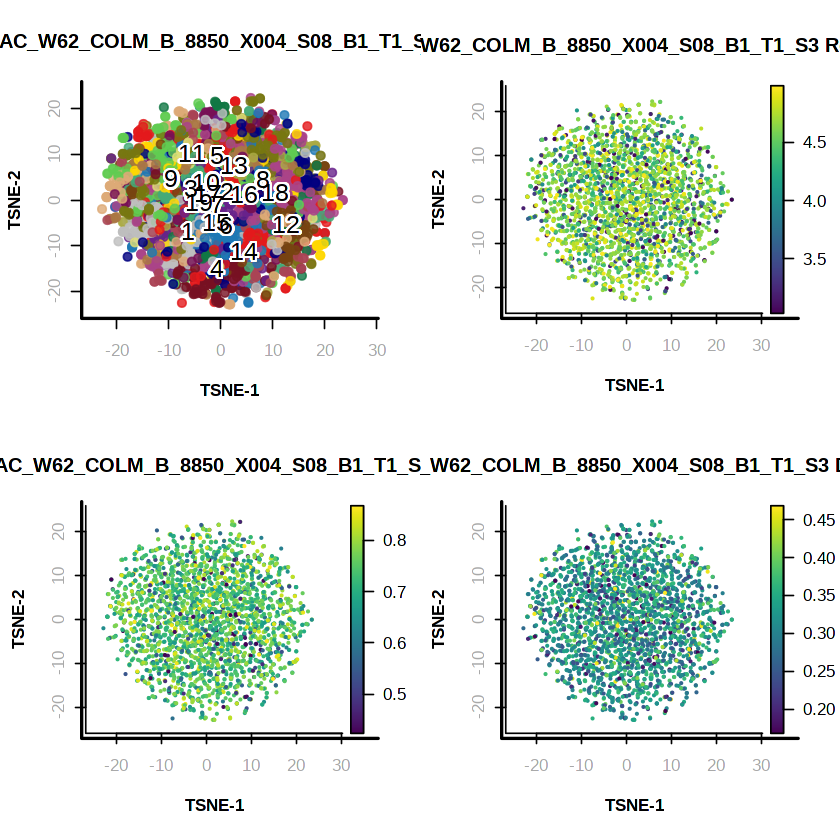

In [69]:
x.sp = runViz(
    obj=x.sp, 
    tmp.folder=tempdir(),
    dims=2,
    eigs.dims=1:20, 
    method="Rtsne",
    seed.use=10)

par(mfrow = c(2, 2))

plotViz(
    obj=x.sp,
    method="tsne", 
    main="scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3 cluster",
    point.color=x.sp@cluster, 
    point.size=1, 
    point.shape=19, 
    point.alpha=0.8, 
    text.add=TRUE,
    text.size=1.5,
    text.color="black",
    text.halo.add=TRUE,
    text.halo.color="white",
    text.halo.width=0.2,
    down.sample=10000,
    legend.add=FALSE)

plotFeatureSingle(
    obj=x.sp,
    feature.value=log(x.sp@metaData[,"passed_filters"]+1,10),
    method="tsne", 
    main="scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3 Read Depth",
    point.size=0.2, 
    point.shape=19, 
    down.sample=10000,
    quantiles=c(0.01, 0.99))

plotFeatureSingle(
    obj=x.sp,
    feature.value=x.sp@metaData$peak_region_fragments / x.sp@metaData$passed_filters,
    method="tsne", 
    main="scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3 FRiP",
    point.size=0.2, 
    point.shape=19, 
    down.sample=10000,
    quantiles=c(0.01, 0.99) # remove outliers
  )
plotFeatureSingle(
    obj=x.sp,
    feature.value=x.sp@metaData$duplicate / x.sp@metaData$total,
    method="tsne", 
    main="scATAC_W62_COLM_B_8850_X004_S08_B1_T1_S3 Duplicate",
    point.size=0.2, 
    point.shape=19, 
    down.sample=10000,
    quantiles=c(0.01, 0.99) # remove outliers
)